Homework 4 predicting poverty in Costa Rica

In [3]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier

This homework is an attempt at using machine learning to assess poverty levels in Costa Rica based on household characteristics. The specific goals are to be able to determine the lowest poverty level households in order to affectively create policy that could positively impact the lives of those who are in need of it the most.

In [4]:
train = pd.read_csv('file:///Users/moirafacer/Desktop/train.csv')
test= pd.read_csv('file:///Users/moirafacer/Desktop/test.csv')

Before any models can be created, I will analyze and clean my data.

In [5]:
train.shape
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [6]:
test.shape
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


In [7]:
train.columns

Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq', 'Target'],
      dtype='object', length=143)

There are a lot of columns, kaggle gives the names of all the columns so I am going to refrain from typing them all out here, and just using kaggle as a guide of which features I am going to examine more closely. 
Important note though, I will be following in others footsteps and focusing my data on heads of household because most data is gathered with the head of household in mind, emaning that is who is surveyed about the majority of the features and who many of the features depend upon.

In [8]:
train.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000
max,2.353477e+06,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,8.000000,...,441.000000,9409.000000,169.000000,441.000000,81.000000,36.000000,64.000000,1369.000000,9409.000000,4.000000


Finding any missing data and evaluating how to best deal with it. 

In [9]:
train.isnull().sum().sort_values(ascending=False).head(6)

rez_esc      7928
v18q1        7342
v2a1         6860
meaneduc        5
SQBmeaned       5
techozinc       0
dtype: int64

Lets deal with rez_esc first, rez_esc stands for years behind in school. We will first want to know what values are possible, and then determine if there are any other correlated features that would help us deal with the missing data. The first correlating factor that we will look at is head of house hold, because most of the features were found by surveying the head of household. 

In [10]:
train.rez_esc.unique()

array([nan,  1.,  0.,  3.,  2.,  4.,  5.])

Only heads of household within the age range of 7-17 can be years behind in school. (This information was found via discussions on kaggle)  Therefore, we need to check what of our rez_esc falls within that category, and what data has heads of household older than 17.

In [11]:
train.loc[(train.parentesco1==1) & (train.rez_esc.isnull()==False)].shape[0]

1

There is only one head of household who is between the ages of 7-17 and is missing an answer. I will drop them because the action will not skew the data much. However, because we know only one point is actually missing data, I can fill all other missing data in with 0, to represent that they are not behind any years in school. I will also drop any data that does not use head of household.

In [12]:
train.rez_esc = 0
train.rez_esc.unique()
train = train.loc[train.parentesco1==1]
train.shape

(2973, 143)

In [13]:
train.isnull().sum().sort_values(ascending=False).head(6)

v18q1          2318
v2a1           2156
meaneduc          3
SQBmeaned         3
abastaguano       0
sanitario2        0
dtype: int64

Next feature will be v18ql. This represents the number of tablets in a household. 

In [14]:
train['v18q1'].isna().sum()

2318

In [15]:
tabletnan=train[train['v18q1'].isnull()]
tabletnan[tabletnan['v18q']==0]['Id'].count()

2318

In [16]:
train['v18q1'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.])

Because these two are the same answers, and the features does not list 0 as an answer, it is safe to assume that the no answers in the Number of Tablets feature means that they do not own a tablet. Because of this I will fill in the missing answers with 0.

In [17]:
train['v18q1']=train['v18q1'].fillna(0)

In [18]:
train.isnull().sum().sort_values(ascending=False).head(6)

v2a1              2156
SQBmeaned            3
meaneduc             3
Target               0
abastaguafuera       0
sanitario1           0
dtype: int64

Now onto v2al, monthly rent payment.

In [19]:
train['v2a1'].isnull().sum()

2156

I got the following idea (and subsequent code) to see if the missing values from monthly rent payment were due to the fact that some people may own house and not rent, from a kernel done by "kati".

In [20]:
norent=train[train['v2a1'].isnull()]
print("Owns his house:", norent[norent['tipovivi1']==1]['Id'].count())
print("Owns his house paying installments", norent[norent['tipovivi2']==1]['Id'].count())
print("Rented ", norent[norent['tipovivi3']==1]['Id'].count())
print("Precarious ", norent[norent['tipovivi4']==1]['Id'].count())
print("Other ", norent[norent['tipovivi5']==1]['Id'].count())
print("Total ", 6860)

Owns his house: 1856
Owns his house paying installments 0
Rented  0
Precarious  46
Other  254
Total  6860


Thanks to this helpful chunk of code we can determine that the vast majority own houses, very few are in a posittion where they are perhpas paying rent but would not let it be recorded for some reason. Since most own houses and are not paying rent, I feel comfortable inputting 0 to fill missing data.

In [21]:
train['v2a1']=train['v2a1'].fillna(0)

In [22]:
train.isnull().sum().sort_values(ascending=False).head(6)

SQBmeaned         3
meaneduc          3
Target            0
abastaguafuera    0
sanitario1        0
coopele           0
dtype: int64

The last two features are both missing the same amount of data, so I am going to take someone's recommendation to determine if they are missing from the same individual.

In [23]:
train.loc[(train.SQBmeaned.isnull()==True) & (train.meaneduc.isnull()==True)].shape[0]

3

It looks like they are! These I will simply replace with the mean.

In [24]:
train.SQBmeaned.fillna(train.SQBmeaned.mean(), inplace=True)
train.meaneduc.fillna(train.meaneduc.mean(), inplace=True)

In [25]:
#Final check to ensure all missing data has been resolved
train.isnull().sum().sort_values(ascending=False).head(6)

Target         0
abastaguano    0
sanitario2     0
sanitario1     0
coopele        0
noelec         0
dtype: int64

Voila! All missing data has been taken care of! Now we can get to a little bit of analysis and some modeling!

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

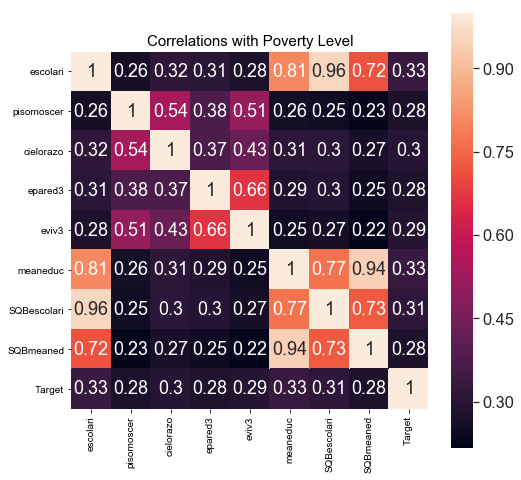

In [27]:
correlations = train.corr()
TargetCorrelations = correlations.index[abs(correlations['Target'])>.275]
f, ax=plt.subplots(figsize=(8,8))
sns.set(font_scale=1.5)
plt.title('Correlations with Poverty Level', fontsize=15);
sns.heatmap(train[TargetCorrelations].corr(), square=True, annot=True);


This histogram (below) gives us the impression that our data is rather skewed, that is, the things we want to focus on, the lowest levels of poverty, are not the most common. I will need to be aware of this when creating my models. Before we model lets look at correlations between the target(poverty levels) and the other features. I got the idea to restrict my correlation map to just features with a correlation of at least .3, to look at the really important features because there are a lot of features avaliable to us.

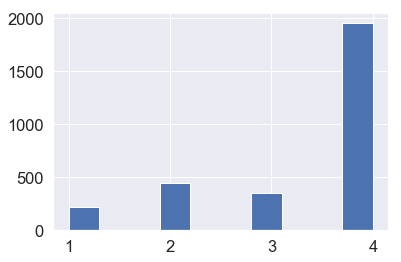

In [28]:
train['Target'].hist()

# Modeling

I am first going to run a randomforest, because it is more accurate than a regular decision tree. However because of how imbalanced the data is I am going to first be using the method of undersampling.  

In [29]:
train_undersampled=train.drop(train.query('Target == 4').sample(frac=.75).index)

I'll create a new histogram to see how my data now looks.

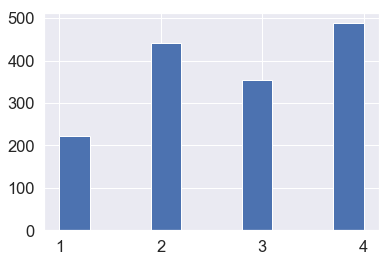

In [30]:
train_undersampled['Target'].hist()

This looks much better. I feel much more confident about running a random forest on the data now.

In [31]:
X=train_undersampled.drop(['Id', 'idhogar', 'Target', 'edjefe', 'edjefa'], axis=1)
y=train_undersampled['Target']

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
X_train.shape

(1205, 138)

In [34]:
y_train.shape

(1205,)

I used shape to check if my data sizes match, because I frequently run into the problem where they do not. Thankfully though they match this time. Now I am going to scale my data and .get dummies.

In [35]:
train['housequality'] = 0
train.loc[(train.epared3==1) & (train.eviv3==1), 'housequality'] = 1
train.drop(['escolari'], inplace=True, axis=1)

In [36]:
predictor = train.Target
train.drop(['Target'], axis=1, inplace=True) 
train = train[['r4t1','pisomoscer','cielorazo', 'meaneduc','eviv3','overcrowding', 'housequality']]

In [37]:
dumb_train = pd.get_dummies(train)

In [38]:
scaler = StandardScaler()
scaler.fit(dumb_train)
scaled_train = scaler.transform(dumb_train)

/Users/moirafacer/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/moirafacer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# Random Forest

In [39]:
y = predictor
x = scaled_train
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

def gridsearching(model):
   model.fit(X_train, y_train)
   print("Best Params: {}".format(model.best_params_))
   y_pred_train = model.predict(X_train)
   print("Train F1: {}".format(f1_score(y_train, y_pred_train, average="macro")))
   print("Test Classification Report:")
   y_pred_test = model.predict(X_test)
   print(classification_report(y_test, y_pred_test))
   print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                    accuracy_score(y_test, y_pred_test)))


Random_Forest = RandomForestClassifier(class_weight='balanced')

model = GridSearchCV(Random_Forest, {'max_depth': [3,4,5,6,7,8], 'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12]}, 
                     scoring="f1_macro")
gridsearching(model)

/Users/moirafacer/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/moirafacer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/moirafacer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best Params: {'max_depth': 8, 'n_estimators': 10}
Train F1: 0.577695618025298
Test Classification Report:
              precision    recall  f1-score   support

           1       0.19      0.35      0.25        43
           2       0.30      0.34      0.32        91
           3       0.20      0.26      0.22        77
           4       0.84      0.68      0.75       384

   micro avg       0.55      0.55      0.55       595
   macro avg       0.38      0.41      0.39       595
weighted avg       0.63      0.55      0.58       595

Train Accuracy: 0.671152228763667	Test accuracy: 0.5512605042016807


So the model worked! The scores are not great, but hey it at least worked. It looks like I am probably over fitting on my training set, not horribly, but still. I am going to run a few more models before coming back and possibly fine tuning things.

# K Nearest Neighbors

In [40]:
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_macro')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

/Users/moirafacer/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Params: {'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
Test Classification Report:
              precision    recall  f1-score   support

           1       0.19      0.37      0.25        43
           2       0.23      0.20      0.21        91
           3       0.15      0.06      0.09        77
           4       0.77      0.80      0.78       384

   micro avg       0.58      0.58      0.58       595
   macro avg       0.33      0.36      0.34       595
weighted avg       0.56      0.58      0.57       595

Train Accuracy: 0.7338099243061396	Test accuracy: 0.5815126050420169


So there is some definite over fitting in my K nearest neighbors model, likely due to how many features there are in the data. My score is better on the K nearest model, however my overfitting is worse on this model than it is on the random forest model interestingly enough. However I feel more confident in my random forest model than I do my K nearest neighbors, because randomforest is a more complicated model, and because I had less over fitting. I also had a better f1 score over all in my randomforest model

In conclusion, I do not feel confident enough in my models ability to predict poverty levels to use them to create public policy. In order for me to reach that level of confidence I need to spend more time fine tuning my models, (I've had time commitments that prevent me from being able to actually spend the time to do this, so i'll just let you know what I would do if I had time). I would focus on my random forest model, I would run more random forests with oversampling, and stack it with my undersampling model. (I would also try different random forest models where I would weight the features differently, rather than having them all weighted the same.) I would likely decrease depth somewhat to try and decrease any over fitting. I would also look more at my features, and see if there was any way for me to increase their weighted averages to help me increase the likelyhood of correctly identifying those in poverty. 